In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.layers import LeakyReLU, PReLU, ELU, ParametricSoftplus, ThresholdedLinear, ThresholdedReLU, SReLU

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.regularizers import l1, l2, l1l2
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras import backend as K

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

Using Theano backend.
Using gpu device 0: GeForce GTX 670 (CNMeM is disabled, CuDNN 4007)


In [2]:
categories = [
  'good_for_lunch', 
  'good_for_dinner', 
  'takes_reservations', 
  'outdoor_seating',
  'restaurant_is_expensive',
  'has_alcohol',
  'has_table_service',
  'ambience_is_classy',
  'good_for_kids'
]

vgg_cols = ['f' + str(i) for i in range(4096)]

In [3]:
data = pd.read_hdf('data/Xtrain_grouped.hdf5')
X, Y = np.array(data[vgg_cols]), np.array(data[categories])

random_state = np.random.RandomState(0)
Xtrain, Xval, ytrain, yval = train_test_split(X, Y, test_size=.2, random_state=random_state)
valset = (Xval, yval)

print Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

(1596, 4096) (400, 4096) (1596, 9) (400, 9)


In [4]:
mlb = MultiLabelBinarizer()
mlb.fit([(0,1,2,3,4,5,6,7,8)])

dataTest = None
for i in range(1, 7):
  part = pd.read_hdf('data/Xtest_grouped_part' + str(i) + '.hdf5', 'Xtest')
  print i, len(part)
  
  if dataTest is None:
    dataTest = part
  else:
    dataTest = dataTest.append(part)
    
Xtest = np.array(dataTest[vgg_cols])
Xtest.shape

1 1637
2 1707
3 1654
4 1746
5 1735
6 1521


(10000, 4096)

In [5]:
def loss(ytrue, ypred):
  return K.sum( (ytrue - ypred) ** 2 )

In [6]:
class f1stopperCallback(Callback):
  def __init__(self):
    self.bestf1val = 0

  def on_epoch_end(self, epoch, logs={}):
    pred = self.model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val = f1_score(yval, pred, average='micro')

    if f1_val > self.bestf1val:
      self.bestf1val = f1_val
      self.model.save_weights('models/tmp_weights.h5', overwrite=True)

# Train models

In [7]:
neurons = range(50, 701, 50)
dropout_vals = np.linspace(.1, .5, 9)
models = []
print neurons
print dropout_vals

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
[ 0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5 ]


# 1-layer nets

In [8]:
def get_1_layer_model(n_neurons, dropout_val):
  model = Sequential()
  np.random.seed(0)
  
  model.add(Dense(n_neurons, input_shape=(4096,), activation='softplus'))
  model.add(Dropout(dropout_val))

  model.add(Dense(9, activation='sigmoid'))
  model.compile(loss=loss, optimizer='adam')
  
  return model

In [8]:
for neu in neurons:
  for dro in dropout_vals:
    print neu, dro,
    model = get_1_layer_model(neu, dro)
    
    model.fit(Xtrain, ytrain, verbose=0, callbacks=[f1stopperCallback()], nb_epoch=200)
    
    pred = model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val_last = f1_score(yval, pred, average='micro')
    
    model.load_weights('models/tmp_weights.h5')
    
    pred = model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val_best = f1_score(yval, pred, average='micro')
    
    print f1_val_last, f1_val_best
    
    models.append((f1_val_best, model))

50 0.1 0.824536376605 0.839407744875
50 0.15 0.826267664173 0.840364880274
50 0.2 0.825636719843 0.839831697055
50 0.25 0.829988851728 0.839215686275
50 0.3 0.82888004548 0.841687907108
50 0.35 0.828456683878 0.839540744889
50 0.4 0.828988828416 0.840915512857
50 0.45 0.833666191155 0.837799717913
50 0.5 0.830654420207 0.837592277115
100 0.1 0.824724809483 0.837446808511
100 0.15 0.826285714286 0.841184767278
100 0.2 0.827861832715 0.841865756542
100 0.25 0.832050185344 0.840993434199
100 0.3 0.831139095592 0.839021615472
100 0.35 0.831146605819 0.842193153354
100 0.4 0.828596037898 0.841782729805
100 0.45 0.836209335219 0.841838173104
100 0.5 0.840750069969 0.841927303466
150 0.1 0.825231481481 0.837276399308
150 0.15 0.826989619377 0.839829302987
150 0.2 0.828439838803 0.840157038699
150 0.25 0.829128440367 0.841779279279
150 0.3 0.834272829763 0.841722595078
150 0.35 0.823529411765 0.840283687943
150 0.4 0.8342760181 0.842706251784
150 0.45 0.833238474673 0.842283776145
150 0.5 0.83

MemoryError: ('Error allocating 9830400 bytes of device memory (out of memory).', "you might consider using 'theano.shared(..., borrow=True)'")

In [9]:
prev = "\
50 0.1 0.824536376605 0.839407744875q\
50 0.15 0.826267664173 0.840364880274q\
50 0.2 0.825636719843 0.839831697055q\
50 0.25 0.829988851728 0.839215686275q\
50 0.3 0.82888004548 0.841687907108q\
50 0.35 0.828456683878 0.839540744889q\
50 0.4 0.828988828416 0.840915512857q\
50 0.45 0.833666191155 0.837799717913q\
50 0.5 0.830654420207 0.837592277115q\
100 0.1 0.824724809483 0.837446808511q\
100 0.15 0.826285714286 0.841184767278q\
100 0.2 0.827861832715 0.841865756542q\
100 0.25 0.832050185344 0.840993434199q\
100 0.3 0.831139095592 0.839021615472q\
100 0.35 0.831146605819 0.842193153354q\
100 0.4 0.828596037898 0.841782729805q\
100 0.45 0.836209335219 0.841838173104q\
100 0.5 0.840750069969 0.841927303466q\
150 0.1 0.825231481481 0.837276399308q\
150 0.15 0.826989619377 0.839829302987q\
150 0.2 0.828439838803 0.840157038699q\
150 0.25 0.829128440367 0.841779279279q\
150 0.3 0.834272829763 0.841722595078q\
150 0.35 0.823529411765 0.840283687943q\
150 0.4 0.8342760181 0.842706251784q\
150 0.45 0.833238474673 0.842283776145q\
150 0.5 0.837510560406 0.84246188594q\
200 0.1 0.825297787862 0.83917640512q\
200 0.15 0.821034282394 0.838255977496q\
200 0.2 0.826326471441 0.839582745983q\
200 0.25 0.821659799882 0.842425920798q\
200 0.3 0.82516671499 0.843907916901q\
200 0.35 0.827526132404 0.843654540405q\
200 0.4 0.835273573923 0.842017275007q\
200 0.45 0.82788798133 0.843510366373q\
200 0.5 0.831092928112 0.843475799604q\
250 0.1 0.818689391713 0.838111298482q\
250 0.15 0.824076766502 0.840364880274q\
250 0.2 0.820421490056 0.84007925276q\
250 0.25 0.82959124928 0.842370039128q\
250 0.3 0.8233559422 0.841387151791q\
250 0.35 0.83134284882 0.840369024322q\
250 0.4 0.830122591944 0.842885657257q\
250 0.45 0.833381797034 0.842105263158q\
250 0.5 0.831146106737 0.845094180489q\
300 0.1 0.819472616633 0.83949930459q\
300 0.15 0.821980538065 0.842395804582q\
300 0.2 0.825174825175 0.838546069315q\
300 0.25 0.827859569649 0.840507726269q\
300 0.3 0.827367205543 0.842374325476q\
300 0.35 0.8345567476 0.841274316324q\
300 0.4 0.826312752452 0.841575859179q\
300 0.45 0.826812428078 0.840993434199q\
300 0.5 0.829084588644 0.841748942172q\
350 0.1 0.828947368421 0.844383561644q\
350 0.15 0.826751225137 0.841722595078q\
350 0.2 0.828018223235 0.839966601726q\
350 0.25 0.833854018745 0.842820730671q\
350 0.3 0.834973943254 0.845852017937q\
350 0.35 0.833574529667 0.841466776951q\
350 0.4 0.828395423878 0.843803056027q\
350 0.45 0.824427480916 0.845939933259q\
350 0.5 0.830439814815 0.843713956171q\
400 0.1 0.828985507246 0.842896935933q\
400 0.15 0.82194979568 0.839038189533q\
400 0.2 0.827666376053 0.84127874369q\
400 0.25 0.815245853942 0.840660879306q\
400 0.3 0.823632130384 0.841206602163q\
400 0.35 0.823939570017 0.843946433452q\
400 0.4 0.828943560058 0.842721695482q\
400 0.45 0.832179930796 0.843176038429q\
400 0.5 0.832947976879 0.844910688971q\
450 0.1 0.824006958539 0.840839160839q\
450 0.15 0.826635376943 0.840915512857q\
450 0.2 0.832283915283 0.839896521989q\
450 0.25 0.826441467676 0.840331333905q\
450 0.3 0.82945067587 0.842574533296q\
450 0.35 0.828497558173 0.843120567376q\
450 0.4 0.830503597122 0.840563380282q\
450 0.45 0.826200873362 0.842499280161q\
450 0.5 0.82818365579 0.846590909091q\
500 0.1 0.817971014493 0.837631056957q\
500 0.15 0.820437956204 0.840942134341q\
500 0.2 0.82102189781 0.840876743524q\
500 0.25 0.831700288184 0.842683632157q\
500 0.3 0.822451994092 0.842543737851q\
500 0.35 0.825806451613 0.84225431889q\
500 0.4 0.83044982699 0.844457175594q\
500 0.45 0.826760151914 0.842979942693q\
500 0.5 0.834470989761 0.843353090601q\
550 0.1 0.82428115016 0.839561674628q\
550 0.15 0.820512820513 0.83775481709q\
550 0.2 0.820046893318 0.840312674484q\
550 0.25 0.821491485614 0.839244851259q\
550 0.3 0.816180844735 0.840786100826q\
550 0.35 0.827327760161 0.842017275007q\
550 0.4 0.825125331761 0.844668345928q\
550 0.45 0.829212190914 0.842165568605q\
550 0.5 0.834851936219 0.841206602163q\
600 0.1 0.831977559607 0.838202247191q\
600 0.15 0.829435253851 0.842693489802q\
600 0.2 0.830690826727 0.83867309328q\
600 0.25 0.835770528684 0.839083632349q\
600 0.3 0.827408256881 0.839329854436q\
600 0.35 0.835570469799 0.841309823678q\
600 0.4 0.830804466075 0.841283124128q\
600 0.45 0.830113636364 0.841779279279q\
600 0.5 0.834565093803 0.842282822603q\
650 0.1 0.632674853177 0.632674853177q\
650 0.15 0.632674853177 0.632674853177q\
650 0.2 0.821230679498 0.839160839161q\
650 0.25 0.815943728019 0.841152263374q\
650 0.3 0.824436197545 0.839060710195q\
650 0.35 0.829604130809 0.840236686391q\
650 0.4 0.82711085583 0.841956460277q\
650 0.45 0.831908831909 0.83908045977q\
650 0.5 0.8314415437 0.841057719647q\
700 0.1 0.827076222981 0.837937909428q\
700 0.15 0.828951088493 0.838978345364q\
700 0.2 0.830166954519 0.841501862998q\
700 0.25 0.834672789897 0.842105263158q\
700 0.3 0.826162790698 0.843949930459q\
700 0.35 0.831694296151 0.841126760563q\
700 0.4 0.833996588971 0.840839160839q\
700 0.45 0.829268292683 0.841573033708q\
700 0.5 0.834252539913 0.842970521542\
"

r = []
for val in prev.split('q'):
  vals = [float(v) for v in val.split(' ')]
  r.append(tuple(vals))

one_layer_more_844 = sorted(r, key=lambda v: -v[3])[:8]
one_layer_more_844

[(450.0, 0.5, 0.82818365579, 0.846590909091),
 (350.0, 0.45, 0.824427480916, 0.845939933259),
 (350.0, 0.3, 0.834973943254, 0.845852017937),
 (250.0, 0.5, 0.831146106737, 0.845094180489),
 (400.0, 0.5, 0.832947976879, 0.844910688971),
 (550.0, 0.4, 0.825125331761, 0.844668345928),
 (500.0, 0.4, 0.83044982699, 0.844457175594),
 (350.0, 0.1, 0.828947368421, 0.844383561644)]

In [10]:
for t in one_layer_more_844:
  neu, dro = int(t[0]), np.float64(t[1])
  print neu, t[1], ':',
  
  model = get_1_layer_model(neu, dro)
  model.fit(Xtrain, ytrain, verbose=0, callbacks=[f1stopperCallback()], nb_epoch=200)
  model.load_weights('models/tmp_weights.h5')
    
  pred = model.predict(Xval)
  pred[pred < .5] = 0
  pred[pred >= .5] = 1
  f1_val_best = f1_score(yval, pred, average='micro')

  print f1_val_best

  models.append((f1_val_best, model))

450 0.5 : 0.846590909091
350 0.45 : 0.845939933259
350 0.3 : 0.845852017937
250 0.5 : 0.845094180489
400 0.5 : 0.844910688971
550 0.4 : 0.844668345928
500 0.4 : 0.844457175594
350 0.1 : 0.844383561644


# 2-layer nets

In [18]:
def get_2_layer_model(n_neurons, dropout_val):
  model = Sequential()
  np.random.seed(0)
  
  model.add(Dense(n_neurons, input_shape=(4096,), activation='softplus'))
  model.add(Dropout(dropout_val))
  
  model.add(Dense(n_neurons, activation='softplus'))
  model.add(Dropout(dropout_val))

  model.add(Dense(9, activation='sigmoid'))
  model.compile(loss=loss, optimizer='adam')
  
  return model

In [10]:
for neu in neurons:
  for dro in dropout_vals:
    print neu, dro,
    model = get_2_layer_model(neu, dro)
    
    model.fit(Xtrain, ytrain, verbose=0, callbacks=[f1stopperCallback()], nb_epoch=200)
    
    pred = model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val_last = f1_score(yval, pred, average='micro')
    
    model.load_weights('models/tmp_weights.h5')
    
    pred = model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val_best = f1_score(yval, pred, average='micro')
    
    print f1_val_last, f1_val_best
    
    models.append((f1_val_best, model))

50 0.1 0.826200873362 0.845039018952
50 0.15 0.822575976845 0.840883352208
50 0.2 0.82562902282 0.841037204059
50 0.25 0.828066106118 0.839630562552
50 0.3 0.837666088966 0.84630404463
50 0.35 0.835957629545 0.840283687943
50 0.4 0.827586206897 0.840902758429
50 0.45 0.828660436137 0.838095238095
50 0.5 0.828579497317 0.835225699252
100 0.1 0.817785527463 0.840839160839
100 0.15 0.821089023336 0.840871021776
100 0.2 0.82318501171 0.84284509418
100 0.25 0.826279964487 0.842075578116
100 0.3 0.827984966753 0.843264614516
100 0.35 0.836322231711 0.842792281498
100 0.4 0.835152211373 0.841985168283
100 0.45 0.838987924094 0.842163970998
100 0.5 0.839782172542 0.839782172542
150 0.1 0.830177854274 0.845982142857
150 0.15 0.829000577701 0.844895657078
150 0.2 0.825248392753 0.84440706476
150 0.25 0.827868852459 0.842371452655
150 0.3 0.834907010014 0.844837421563
150 0.35 0.838985465945 0.840687679083
150 0.4 0.839750849377 0.842016333427
150 0.45 0.840909090909 0.844406587166
150 0.5 0.8406

MemoryError: Error allocating 9011200 bytes of device memory (out of memory).
Apply node that caused the error: GpuDot22Scalar(GpuDimShuffle{1,0}.0, GpuElemwise{Composite{((i0 * i1) * scalar_sigmoid(i2))}}[(0, 0)].0, HostFromGpu.0)
Toposort index: 112
Inputs types: [CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix), TensorType(float32, scalar)]
Inputs shapes: [(4096, 128), (128, 550), ()]
Inputs strides: [(1, 4096), (550, 1), ()]
Inputs values: ['not shown', 'not shown', array(0.10000002384185791, dtype=float32)]
Outputs clients: [[GpuElemwise{Composite{((i0 * i1) + i2)}}[(0, 1)](GpuDimShuffle{x,x}.0, <CudaNdarrayType(float32, matrix)>, GpuDot22Scalar.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [16]:
prev = "\
50 0.1 0.826200873362 0.845039018952q\
50 0.15 0.822575976845 0.840883352208q\
50 0.2 0.82562902282 0.841037204059q\
50 0.25 0.828066106118 0.839630562552q\
50 0.3 0.837666088966 0.84630404463q\
50 0.35 0.835957629545 0.840283687943q\
50 0.4 0.827586206897 0.840902758429q\
50 0.45 0.828660436137 0.838095238095q\
50 0.5 0.828579497317 0.835225699252q\
100 0.1 0.817785527463 0.840839160839q\
100 0.15 0.821089023336 0.840871021776q\
100 0.2 0.82318501171 0.84284509418q\
100 0.25 0.826279964487 0.842075578116q\
100 0.3 0.827984966753 0.843264614516q\
100 0.35 0.836322231711 0.842792281498q\
100 0.4 0.835152211373 0.841985168283q\
100 0.45 0.838987924094 0.842163970998q\
100 0.5 0.839782172542 0.839782172542q\
150 0.1 0.830177854274 0.845982142857q\
150 0.15 0.829000577701 0.844895657078q\
150 0.2 0.825248392753 0.84440706476q\
150 0.25 0.827868852459 0.842371452655q\
150 0.3 0.834907010014 0.844837421563q\
150 0.35 0.838985465945 0.840687679083q\
150 0.4 0.839750849377 0.842016333427q\
150 0.45 0.840909090909 0.844406587166q\
150 0.5 0.840660879306 0.842458100559q\
200 0.1 0.820886814469 0.844884488449q\
200 0.15 0.823259810942 0.841694537347q\
200 0.2 0.827149841818 0.843408175014q\
200 0.25 0.823357664234 0.842312008979q\
200 0.3 0.830795748348 0.843741169822q\
200 0.35 0.834968263128 0.841896111269q\
200 0.4 0.83284457478 0.844581349762q\
200 0.45 0.838299103269 0.844646407271q\
200 0.5 0.838001732602 0.844998583168q\
250 0.1 0.828248587571 0.840832395951q\
250 0.15 0.831913685406 0.841756420878q\
250 0.2 0.828870779977 0.84171848502q\
250 0.25 0.822873900293 0.842075892857q\
250 0.3 0.831034482759 0.844031531532q\
250 0.35 0.829113924051 0.841116173121q\
250 0.4 0.831837916064 0.846305141894q\
250 0.45 0.823766945486 0.844798180785q\
250 0.5 0.829128440367 0.841224018476q\
300 0.1 0.820795817601 0.839831697055q\
300 0.15 0.817285382831 0.840233398166q\
300 0.2 0.832245245529 0.842075256556q\
300 0.25 0.821347031963 0.83904109589q\
300 0.3 0.821366024518 0.848384424192q\
300 0.35 0.823149236193 0.841865756542q\
300 0.4 0.836279339322 0.843891402715q\
300 0.45 0.831797235023 0.842165568605q\
300 0.5 0.832095945174 0.843490701001q\
350 0.1 0.82612533098 0.84154235857q\
350 0.15 0.827293318233 0.837362637363q\
350 0.2 0.827389443652 0.83978824185q\
350 0.25 0.823462088698 0.842395804582q\
350 0.3 0.823899371069 0.841367713004q\
350 0.35 0.82264586944 0.841359773371q\
350 0.4 0.827546296296 0.84606613455q\
350 0.45 0.827020915772 0.845319634703q\
350 0.5 0.831042382589 0.844078386822q\
400 0.1 0.823462414579 0.841896111269q\
400 0.15 0.826928633343 0.841724617524q\
400 0.2 0.824964539007 0.841539332201q\
400 0.25 0.824849007765 0.843137254902q\
400 0.3 0.830489192264 0.844943820225q\
400 0.35 0.827705627706 0.843533647189q\
400 0.4 0.831486217675 0.842965886665q\
400 0.45 0.831949613513 0.844166903207q\
400 0.5 0.831047563467 0.844119302195q\
450 0.1 0.827684420393 0.838526912181q\
450 0.15 0.828003457217 0.839321644151q\
450 0.2 0.829142857143 0.840695354802q\
450 0.25 0.820292347377 0.839554317549q\
450 0.3 0.825757575758 0.842015371477q\
450 0.35 0.824374820351 0.841224018476q\
450 0.4 0.827966347549 0.843634292224q\
450 0.45 0.832664756447 0.841305571187q\
450 0.5 0.844137136272 0.846022727273q\
500 0.1 0.822632659044 0.840889890172q\
500 0.15 0.834090909091 0.83995584989q\
500 0.2 0.828341013825 0.843246247916q\
500 0.25 0.833944178179 0.84524137931q\
500 0.3 0.818468597648 0.840979453983q\
500 0.35 0.826939471441 0.84180949705q\
500 0.4 0.830167280975 0.842703009654q\
500 0.45 0.829379822807 0.843837144451q\
500 0.5 0.834233721922 0.843359818388q\
550 0.1 0.82481962482 0.837563451777q\
550 0.15 0.832087406555 0.839021615472q\
550 0.2 0.824934459656 0.841724617524q\
550 0.25 0.827485380117 0.841340782123q\
550 0.3 0.823322590097 0.843219159009q\
550 0.35 0.830513335245 0.843615494978q\
550 0.4 0.830725462304 0.841545352744q\
550 0.45 0.830318690784 0.845464725644q\
550 0.5 0.836805555556 0.842105263158q\
600 0.1 0.821602987647 0.838346921563q\
600 0.15 0.833656241351 0.83972027972q\
600 0.2 0.824956672444 0.842105263158q\
600 0.25 0.825442099258 0.840832395951q\
600 0.3 0.826674331705 0.840226628895q\
600 0.35 0.833285998296 0.846543001686q\
600 0.4 0.826163818503 0.843454038997q\
600 0.45 0.826174690112 0.843907916901q\
600 0.5 0.824682814302 0.842781345993q\
650 0.1 0.828751431844 0.836664762993q\
650 0.15 0.826436781609 0.841558441558q\
650 0.2 0.82702858793 0.840742824986q\
650 0.25 0.827766482719 0.842671194114q\
650 0.3 0.835734870317 0.845390070922q\
650 0.35 0.824153166421 0.840979453983q\
650 0.4 0.836630864895 0.840876743524q\
650 0.45 0.830155470813 0.843441466855q\
650 0.5 0.832662449684 0.841893830703q\
700 0.1 0.525458248473 0.525458248473q\
700 0.15 0.636412172985 0.636412172985q\
700 0.2 0.827843024921 0.83994374121q\
700 0.25 0.82585596222 0.840767927724q\
700 0.3 0.826705370102 0.839807201588q\
700 0.35 0.826099621322 0.841206602163q\
700 0.4 0.824351878823 0.842642472356q\
700 0.45 0.829971181556 0.841059602649q\
700 0.5 0.837410071942 0.843064653945\
"

r = []
for val in prev.split('q'):
  vals = [float(v) for v in val.split(' ')]
  r.append(tuple(vals))
sorted(r, key=lambda v: -v[3])[:26]

two_layer_more_844 = sorted(r, key=lambda v: -v[3])[:26]
two_layer_more_844

[(300.0, 0.3, 0.821366024518, 0.848384424192),
 (600.0, 0.35, 0.833285998296, 0.846543001686),
 (250.0, 0.4, 0.831837916064, 0.846305141894),
 (50.0, 0.3, 0.837666088966, 0.84630404463),
 (350.0, 0.4, 0.827546296296, 0.84606613455),
 (450.0, 0.5, 0.844137136272, 0.846022727273),
 (150.0, 0.1, 0.830177854274, 0.845982142857),
 (550.0, 0.45, 0.830318690784, 0.845464725644),
 (650.0, 0.3, 0.835734870317, 0.845390070922),
 (350.0, 0.45, 0.827020915772, 0.845319634703),
 (500.0, 0.25, 0.833944178179, 0.84524137931),
 (50.0, 0.1, 0.826200873362, 0.845039018952),
 (200.0, 0.5, 0.838001732602, 0.844998583168),
 (400.0, 0.3, 0.830489192264, 0.844943820225),
 (150.0, 0.15, 0.829000577701, 0.844895657078),
 (200.0, 0.1, 0.820886814469, 0.844884488449),
 (150.0, 0.3, 0.834907010014, 0.844837421563),
 (250.0, 0.45, 0.823766945486, 0.844798180785),
 (200.0, 0.45, 0.838299103269, 0.844646407271),
 (200.0, 0.4, 0.83284457478, 0.844581349762),
 (150.0, 0.2, 0.825248392753, 0.84440706476),
 (150.0, 0.45

In [19]:
for t in two_layer_more_844:
  neu, dro = int(t[0]), np.float64(t[1])
  print neu, t[1], ':',
  
  model = get_2_layer_model(neu, dro)
  model.fit(Xtrain, ytrain, verbose=0, callbacks=[f1stopperCallback()], nb_epoch=200)
  model.load_weights('models/tmp_weights.h5')
    
  pred = model.predict(Xval)
  pred[pred < .5] = 0
  pred[pred >= .5] = 1
  f1_val_best = f1_score(yval, pred, average='micro')

  print f1_val_best

  models.append((f1_val_best, model))

300 0.3 : 0.848384424192
600 0.35 : 0.846543001686
250 0.4 : 0.846305141894
50 0.3 : 0.84630404463
350 0.4 : 0.84606613455
450 0.5 : 0.846022727273
150 0.1 : 0.845982142857
550 0.45 : 0.845464725644
650 0.3 : 0.845390070922
350 0.45 : 0.845319634703
500 0.25 : 0.84524137931
50 0.1 : 0.845039018952
200 0.5 : 0.844998583168
400 0.3 : 0.844943820225
150 0.15 : 0.844895657078
200 0.1 : 0.844884488449
150 0.3 : 0.844837421563
250 0.45 : 0.844798180785
200 0.45 : 0.844646407271
200 0.4 : 0.844581349762
150 0.2 : 0.84440706476
150 0.45 : 0.844406587166
400 0.45 : 0.844166903207
400 0.5 : 0.844119302195
350 0.5 : 0.844078386822
250 0.3 : 0.844031531532


# 3-layer nets

In [20]:
def get_3_layer_model(n_neurons, dropout_val):
  model = Sequential()
  np.random.seed(0)
  
  model.add(Dense(n_neurons, input_shape=(4096,), activation='softplus'))
  model.add(Dropout(dropout_val))
  
  model.add(Dense(n_neurons, activation='softplus'))
  model.add(Dropout(dropout_val))
  
  model.add(Dense(n_neurons, activation='softplus'))
  model.add(Dropout(dropout_val))

  model.add(Dense(9, activation='sigmoid'))
  model.compile(loss=loss, optimizer='adam')
  
  return model

In [8]:
for neu in neurons:
  for dro in dropout_vals:
    print neu, dro,
    model = get_3_layer_model(neu, dro)
    
    model.fit(Xtrain, ytrain, verbose=0, callbacks=[f1stopperCallback()], nb_epoch=200)
    
    pred = model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val_last = f1_score(yval, pred, average='micro')
    
    model.load_weights('models/tmp_weights.h5')
    
    pred = model.predict(Xval)
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    f1_val_best = f1_score(yval, pred, average='micro')
    
    print f1_val_last, f1_val_best
    
    models.append((f1_val_best, model))

50 0.1 0.829625457618 0.842224103867
50 0.15 0.83063583815 0.844031531532
50 0.2 0.833476149672 0.842164599775
50 0.25 0.827306913509 0.844571428571
50 0.3 0.832027850305 0.840490797546
50 0.35 0.823152995928 0.831161473088
50 0.4 0.824200913242 0.831977559607
50 0.45 0.824506155167 0.830369743156
50 0.5 0.813230681494 0.818953711312
100 0.1 0.818420285631 0.841657207719
100 0.15 0.823633156966 0.842792281498
100 0.2 0.828377980571 0.843319268636
100 0.25 0.830308268511 0.84329199549
100 0.3 0.821071218364 0.841839596186
100 0.35 0.835120254999 0.841956460277
100 0.4 0.8265129683 0.84009009009
100 0.45 0.829924348557 0.83994374121
100 0.5 0.828808230923 0.834324553951
150 0.1 0.828767123288 0.840695354802
150 0.15 0.834797393029 0.841901603096
150 0.2 0.829873125721 0.841463414634
150 0.25 0.83003725996 0.842665173572
150 0.3 0.826036866359 0.842105263158
150 0.35 0.838525292941 0.842256764537
150 0.4 0.828719723183 0.845431255337
150 0.45 0.835507657402 0.837822671156
150 0.5 0.828854

MemoryError: ('Error allocating 9011200 bytes of device memory (out of memory).', "you might consider using 'theano.shared(..., borrow=True)'")

In [24]:
prev = "\
50 0.1 0.829625457618 0.842224103867q\
50 0.15 0.83063583815 0.844031531532q\
50 0.2 0.833476149672 0.842164599775q\
50 0.25 0.827306913509 0.844571428571q\
50 0.3 0.832027850305 0.840490797546q\
50 0.35 0.823152995928 0.831161473088q\
50 0.4 0.824200913242 0.831977559607q\
50 0.45 0.824506155167 0.830369743156q\
50 0.5 0.813230681494 0.818953711312q\
100 0.1 0.818420285631 0.841657207719q\
100 0.15 0.823633156966 0.842792281498q\
100 0.2 0.828377980571 0.843319268636q\
100 0.25 0.830308268511 0.84329199549q\
100 0.3 0.821071218364 0.841839596186q\
100 0.35 0.835120254999 0.841956460277q\
100 0.4 0.8265129683 0.84009009009q\
100 0.45 0.829924348557 0.83994374121q\
100 0.5 0.828808230923 0.834324553951q\
150 0.1 0.828767123288 0.840695354802q\
150 0.15 0.834797393029 0.841901603096q\
150 0.2 0.829873125721 0.841463414634q\
150 0.25 0.83003725996 0.842665173572q\
150 0.3 0.826036866359 0.842105263158q\
150 0.35 0.838525292941 0.842256764537q\
150 0.4 0.828719723183 0.845431255337q\
150 0.45 0.835507657402 0.837822671156q\
150 0.5 0.828854314003 0.8342760181q\
200 0.1 0.82754727632 0.842193153354q\
200 0.15 0.830934236523 0.846543001686q\
200 0.2 0.825072886297 0.845787853345q\
200 0.25 0.83338080319 0.840818646958q\
200 0.3 0.835471913316 0.84512645638q\
200 0.35 0.833766984678 0.845261669024q\
200 0.4 0.831454177508 0.846622369878q\
200 0.45 0.836248924577 0.845086377797q\
200 0.5 0.832472748135 0.84161849711q\
250 0.1 0.825497548313 0.843360133075q\
250 0.15 0.828886310905 0.847065462754q\
250 0.2 0.825693430657 0.843115124153q\
250 0.25 0.829368575624 0.842438182864q\
250 0.3 0.831102250071 0.843837144451q\
250 0.35 0.837640449438 0.843041606887q\
250 0.4 0.8352402746 0.844507042254q\
250 0.45 0.840022611645 0.842639593909q\
250 0.5 0.838089855891 0.841449603624q\
300 0.1 0.813114754098 0.842721695482q\
300 0.15 0.828637147786 0.844280860702q\
300 0.2 0.83010130246 0.844444444444q\
300 0.25 0.828637147786 0.841463414634q\
300 0.3 0.834030683403 0.841078600115q\
300 0.35 0.833804409271 0.84280565567q\
300 0.4 0.842165242165 0.843421426542q\
300 0.45 0.836353340883 0.845313398505q\
300 0.5 0.839633447881 0.841074426413q\
350 0.1 0.824169530355 0.84284509418q\
350 0.15 0.824039295001 0.841598186455q\
350 0.2 0.820558526441 0.843917583968q\
350 0.25 0.82684105772 0.843583263128q\
350 0.3 0.818580192813 0.842841163311q\
350 0.35 0.830698476574 0.843148357871q\
350 0.4 0.828776978417 0.845272206304q\
350 0.45 0.83419988446 0.845936794582q\
350 0.5 0.839965645577 0.844266970907q\
400 0.1 0.817770232032 0.838963963964q\
400 0.15 0.822402785839 0.840068298236q\
400 0.2 0.829144309517 0.84107987754q\
400 0.25 0.816486161252 0.841985815603q\
400 0.3 0.833188782885 0.841775754126q\
400 0.35 0.827259259259 0.841453111799q\
400 0.4 0.829000577701 0.843541202673q\
400 0.45 0.835984958056 0.84406779661q\
400 0.5 0.835667333524 0.84406779661q\
450 0.1 0.821971830986 0.841606246514q\
450 0.15 0.830362277171 0.84018768976q\
450 0.2 0.815305815005 0.840407470289q\
450 0.25 0.818751866229 0.840973401245q\
450 0.3 0.826036193812 0.840909090909q\
450 0.35 0.836209335219 0.842763719079q\
450 0.4 0.832552693208 0.843199537973q\
450 0.45 0.835051546392 0.846912884127q\
450 0.5 0.840695354802 0.844005641749q\
500 0.1 0.826818830243 0.840413943355q\
500 0.15 0.831778343229 0.844594594595q\
500 0.2 0.833996588971 0.842490842491q\
500 0.25 0.827080394922 0.844720496894q\
500 0.3 0.825239895318 0.846240179574q\
500 0.35 0.834807417974 0.841536273115q\
500 0.4 0.833765485451 0.845046570703q\
500 0.45 0.832904884319 0.843359818388q\
500 0.5 0.828855140187 0.843714609287q\
550 0.1 0.827367205543 0.839187705818q\
550 0.15 0.821367030442 0.840859030837q\
550 0.2 0.817883755589 0.839977540707q\
550 0.25 0.829393335232 0.842933408261q\
550 0.3 0.82637875693 0.842105263158q\
550 0.35 0.834508034959 0.843654540405q\
550 0.4 0.8359308586 0.842989084803q\
550 0.45 0.834474885845 0.842970521542q\
550 0.5 0.836646499568 0.844808126411q\
600 0.1 0.820098180768 0.839416058394q\
600 0.15 0.826036866359 0.837524724498q\
600 0.2 0.820303383897 0.839331255313q\
600 0.25 0.818262674177 0.840636338264q\
600 0.3 0.828306264501 0.840915512857q\
600 0.35 0.822136726842 0.842933408261q\
600 0.4 0.830518345952 0.843011947763q\
600 0.45 0.826239067055 0.841477272727q\
600 0.5 0.83013379872 0.848054529963q\
650 0.1 0.525458248473 0.525458248473q\
650 0.15 0.825746593215 0.841355739106q\
650 0.2 0.814127506735 0.839965645577q\
650 0.25 0.830005704507 0.842495015665q\
650 0.3 0.831021794509 0.843153999431q\
650 0.35 0.82802182027 0.841332580463q\
650 0.4 0.828412744811 0.84292901062q\
650 0.45 0.835734870317 0.846000569314q\
650 0.5 0.833285509326 0.842760180995q\
700 0.1 0.585774058577 0.585774058577q\
700 0.15 0.632674853177 0.632674853177q\
700 0.2 0.585774058577 0.585774058577q\
700 0.25 0.831132340545 0.841570177916q\
700 0.3 0.825517040489 0.841716396704q\
700 0.35 0.834807417974 0.840103716508q\
700 0.4 0.83484676504 0.842405243659q\
700 0.45 0.83587237712 0.842731652026q\
700 0.5 0.834064969271 0.842397336293\
"

r = []
for val in prev.split('q'):
  vals = [float(v) for v in val.split(' ')]
  r.append(tuple(vals))

three_layer_more_844 = sorted(r, key=lambda v: -v[3])[:28]
three_layer_more_844

[(600.0, 0.5, 0.83013379872, 0.848054529963),
 (250.0, 0.15, 0.828886310905, 0.847065462754),
 (450.0, 0.45, 0.835051546392, 0.846912884127),
 (200.0, 0.4, 0.831454177508, 0.846622369878),
 (200.0, 0.15, 0.830934236523, 0.846543001686),
 (500.0, 0.3, 0.825239895318, 0.846240179574),
 (650.0, 0.45, 0.835734870317, 0.846000569314),
 (350.0, 0.45, 0.83419988446, 0.845936794582),
 (200.0, 0.2, 0.825072886297, 0.845787853345),
 (150.0, 0.4, 0.828719723183, 0.845431255337),
 (300.0, 0.45, 0.836353340883, 0.845313398505),
 (350.0, 0.4, 0.828776978417, 0.845272206304),
 (200.0, 0.35, 0.833766984678, 0.845261669024),
 (200.0, 0.3, 0.835471913316, 0.84512645638),
 (200.0, 0.45, 0.836248924577, 0.845086377797),
 (500.0, 0.4, 0.833765485451, 0.845046570703),
 (550.0, 0.5, 0.836646499568, 0.844808126411),
 (500.0, 0.25, 0.827080394922, 0.844720496894),
 (500.0, 0.15, 0.831778343229, 0.844594594595),
 (50.0, 0.25, 0.827306913509, 0.844571428571),
 (250.0, 0.4, 0.8352402746, 0.844507042254),
 (300.0,

In [26]:
for t in three_layer_more_844:
  neu, dro = int(t[0]), np.float64(t[1])
  print neu, t[1], ':',
  
  model = get_3_layer_model(neu, dro)
  model.fit(Xtrain, ytrain, verbose=0, callbacks=[f1stopperCallback()], nb_epoch=200)
  model.load_weights('models/tmp_weights.h5')
    
  pred = model.predict(Xval)
  pred[pred < .5] = 0
  pred[pred >= .5] = 1
  f1_val_best = f1_score(yval, pred, average='micro')

  print f1_val_best

  models.append((f1_val_best, model))

600 0.5 : 0.848054529963
250 0.15 : 0.847065462754
450 0.45 : 0.846912884127
200 0.4 : 0.846622369878
200 0.15 : 0.846543001686
500 0.3 : 0.846240179574
650 0.45 : 0.846000569314
350 0.45 : 0.845936794582
200 0.2 : 0.845787853345
150 0.4 : 0.845431255337
300 0.45 : 0.847178905585
350 0.4 : 0.845272206304
200 0.35 : 0.845261669024
200 0.3 : 0.84512645638
200 0.45 : 0.845086377797
500 0.4 : 0.845046570703
550 0.5 : 0.844808126411
500 0.25 : 0.844720496894
500 0.15 : 0.844594594595
50 0.25 : 0.844571428571
250 0.4 : 0.844507042254
300 0.2 : 0.844444444444
300 0.15 : 0.844280860702
350 0.5 : 0.844266970907
400 0.45 : 0.84406779661
400 0.5 : 0.84406779661
50 0.15 : 0.844031531532
450 0.5 : 0.844005641749


In [27]:
len(models)

62

# Build an ensemble

In [28]:
sorted_by_f1val = sorted(models, key=lambda t: -t[0])
for s in sorted_by_f1val:
  print s[0],

0.848384424192 0.848054529963 0.847178905585 0.847065462754 0.846912884127 0.846622369878 0.846590909091 0.846543001686 0.846543001686 0.846305141894 0.84630404463 0.846240179574 0.84606613455 0.846022727273 0.846000569314 0.845982142857 0.845939933259 0.845936794582 0.845852017937 0.845787853345 0.845464725644 0.845431255337 0.845390070922 0.845319634703 0.845272206304 0.845261669024 0.84524137931 0.84512645638 0.845094180489 0.845086377797 0.845046570703 0.845039018952 0.844998583168 0.844943820225 0.844910688971 0.844895657078 0.844884488449 0.844837421563 0.844808126411 0.844798180785 0.844720496894 0.844668345928 0.844646407271 0.844594594595 0.844581349762 0.844571428571 0.844507042254 0.844457175594 0.844444444444 0.84440706476 0.844406587166 0.844383561644 0.844280860702 0.844266970907 0.844166903207 0.844119302195 0.844078386822 0.84406779661 0.84406779661 0.844031531532 0.844031531532 0.844005641749


In [29]:
def get_best_models(n_models):
  best_models = []
  for s in sorted_by_f1val:
    best_models.append(s[1])
    if len(best_models) >= n_models:
      break
  return best_models

def predict_ensemble(models, X):
  pred = np.zeros((len(models), X.shape[0], 9))
  for idx, model in enumerate(models):
    pred[idx] = model.predict(X)    
  result = pred.mean(axis=0)
  assert result.shape[0] == X.shape[0]
  assert result.shape[1] == 9
  return result

In [30]:
f1s = []

for i in range(len(models)):  
  pred = predict_ensemble(get_best_models(i + 1), Xval)
  pred[pred < .5] = 0
  pred[pred > .5] = 1
  
  f1s.append(f1_score(yval, pred, average='micro'))

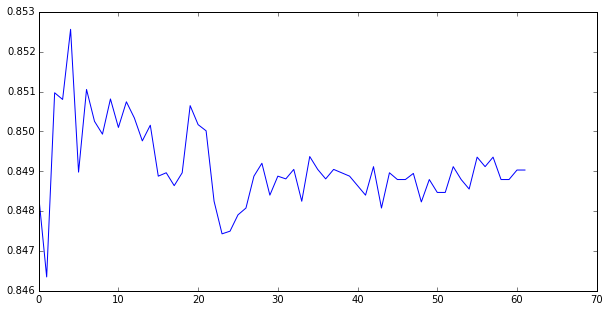

In [31]:
plt.plot(np.arange(len(models)), f1s)

In [32]:
np.argmax(f1s)

4

In [43]:
f1s[10:20]

[0.85009806668534604,
 0.85074208905068605,
 0.85033632286995509,
 0.84976130300477393,
 0.85015462468372216,
 0.84887640449438206,
 0.84896125772038189,
 0.84863802302723945,
 0.84896125772038189,
 0.8506457046603032]

In [47]:
pred = predict_ensemble(get_best_models(20), Xval)
pred[pred < .5] = 0
pred[pred > .5] = 1

f1_score(yval, pred, average='micro')

0.8506457046603032

# Test data time!

In [48]:
pred = predict_ensemble(get_best_models(20), Xtest)

pred[pred < .5] = 0
pred[pred > .5] = 1
labels = mlb.inverse_transform(pred)
labels_str = [' '.join(map(str, l)) for l in labels]
results = pd.DataFrame({'business_id': dataTest.index, 'labels': pd.Series(labels_str)})
results.head()

,business_id,labels
0,003sg,1 2 3 5 6 8
1,00er5,1 2 3 5 6 8
2,00kad,1 2 3 5 6 8
3,00mc6,1 2 5 6
4,00q7x,1 2 4 5 6 7


In [49]:
results.to_csv('results/forth_ensemble_20.csv', index=False)

# RESULT

5,4,7,10,20 models -- no improvements. Max 81.34